### Import packages

## Download and setup the Elasticsearch instance

For demo purposes, the open-source version of the elasticsearch package is used.


In [ ]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


Run the instance as a daemon process

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [ ]:
# Sleep for few seconds to let the instance start.
time.sleep(20)

Once the instance has been started, grep for `elasticsearch` in the processes list to confirm the availability.

In [ ]:
%%bash

ps -ef | grep elasticsearch

root         547     545  0 12:07 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon       548     547 99 12:07 ?        00:00:20 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-15578183390717025849 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:fileco

query the base endpoint to retrieve information about the cluster.

In [ ]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "b925fee1cd71",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "Ev9LT1qLTV-esAYZCIoOKQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
!pip install elasticsearch-dsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from elasticsearch import Elasticsearch

import elasticsearch_dsl

In [ ]:
ES_NODES = "http://localhost:9200"
es = Elasticsearch(hosts = [ES_NODES])

elasticsearch_dsl.connections.add_connection('python_client', es)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Use the corpus from exercise no. 1 or any other Polish corpus of comparable size.

In [ ]:
PATH = "/content/drive/MyDrive/Nauka/data science/nlp/ustawy/"
# %config Completer.use_jedi = False

In [ ]:
import os

In [ ]:
file_names = []
for file in os.listdir(PATH):
    file_names.append(file)

file_names.remove('.DS_Store')
file_names.remove('.ipynb_checkpoints')

In [ ]:
file_names[0]

'2004_1055.txt'

In [ ]:
len(file_names)

1178

In [ ]:
laws_content= []
for file_name in file_names:
      p = os.path.join(PATH, file_name)
      with open(p, "r") as f:
          laws_content.append(f.read())

In [ ]:
len(laws_content)

1178

## Make sure the texts in the corpus does not contain HTML code.

In [ ]:
import re

def remove_html_tags(text):
  pattern = re.compile(r'<.*?>')
  return pattern.sub('', text)

In [ ]:
laws = [ remove_html_tags(k) for k in  laws_content]


In [ ]:
laws = [re.sub(r"\s+", " ", l) for l in laws ]

## Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

nlp = spacy.load("pl_core_news_sm")

In [ ]:
!python -m spacy download pl_core_news_sm

2022-11-10 18:06:13.397338: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.1 MB 3.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [ ]:
import spacy

nlp = spacy.load('pl_core_news_sm')
tokenizer = nlp.tokenizer

In [ ]:
from spacy.tokenizer import Tokenizer
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)

Compute frequency list for each of the processed files.

Aggregate the result to obtain one global frequency list.

Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

In [ ]:
import string
def change_punctuation(law_content):
    characters = list(law_content)
    for i in range(len(characters)):
        if characters[i] in string.punctuation:
            characters[i] = " "
    return "".join(characters)


In [ ]:
from collections import Counter
laws_tokens = {}

i = 0
for i, law in enumerate(laws):
    content = change_punctuation(law.lower())
    content = tokenizer(content)
    tokens = []
    for token in content:
      if len(token.text) > 1 and not token.is_punct and not token.is_digit and not token.is_stop and token.is_alpha:
        tokens.append(token.text) 

    laws_tokens[file_names[i]] = tokens
   

In [ ]:
laws_tokens['2004_1055.txt']

In [ ]:
count_tokens_per_law = {}

for file_name, tokens in  laws_tokens.items():
  count_tokens_per_law[file_name] = Counter(tokens)

In [ ]:
count_tokens_per_law['2004_1055.txt']

Counter({'tekst': 1,
         'ustawy': 13,
         'ustalony': 1,
         'ostatecznie': 1,
         'rozpatrzeniu': 1,
         'poprawek': 1,
         'senatu': 1,
         'ustawa': 3,
         'dnia': 14,
         'listopada': 1,
         'zmianie': 1,
         'samorządach': 2,
         'zawodowych': 19,
         'architektów': 5,
         'inżynierów': 3,
         'budownictwa': 31,
         'urbanistów': 3,
         'prawo': 5,
         'budowlane': 4,
         'art': 37,
         'ustawie': 6,
         'grudnia': 1,
         'dz': 7,
         'nr': 23,
         'poz': 23,
         'późn': 3,
         'zm': 3,
         'wprowadza': 3,
         'następujące': 8,
         'zmiany': 5,
         'dodaje': 10,
         'brzmieniu': 11,
         'ilekroć': 2,
         'mowa': 29,
         'państwach': 2,
         'członkowskich': 9,
         'rozumie': 2,
         'państwa': 21,
         'członkowskie': 4,
         'unii': 9,
         'europejskiej': 9,
         'szwajcarską': 1,
 

In [ ]:
counter_global = Counter({})
for content in count_tokens_per_law.values():
    counter_global.update(content)

In [ ]:
counter_global.most_common(15)

[('art', 82963),
 ('ust', 53624),
 ('poz', 45245),
 ('nr', 44950),
 ('mowa', 28783),
 ('pkt', 19124),
 ('dnia', 17954),
 ('ustawy', 13093),
 ('brzmienie', 10576),
 ('spraw', 10021),
 ('otrzymuje', 9835),
 ('dz', 8888),
 ('dodaje', 8422),
 ('pracy', 7622),
 ('minister', 7502)]

In [ ]:
len(counter_global)

55019

## Make a plot in a logarithmic scale (for X and Y):
X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,

Y-axis should contain the number of occurrences of the term with given rank.

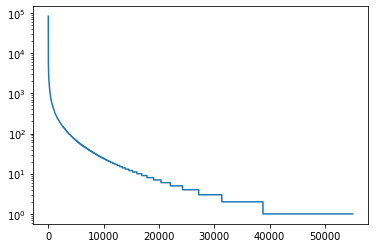

In [ ]:
import matplotlib.pyplot as plt
sort_freq = sorted(counter_global.values(), reverse=True)
plt.plot(sort_freq)
plt.yscale('log')
plt.show()

### Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [ ]:
!git clone https://github.com/ryszardtuora/nlpinactionpl.git
!python3 -m pip install -r nlpinactionpl/requirements.txt

# instalacja morfeusza
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2


# instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

Cloning into 'nlpinactionpl'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 9), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 5.0 MB/s 
     |████████████████████████████████| 1.4 MB 46.7 MB/s 
     |████████████████████████████████| 3.7 MB 39.5 MB/s 
     |████████████████████████████████| 2.1 MB 39.2 MB/s 
     |████████████████████████████████| 208 kB 44.1 MB/s 
     |████████████████████████████████| 880 kB 49.7 MB/s 
     |████████████████████████████████| 2.9 MB 27.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=793a3ef8e86062fe2b11beaccf6b3811a964e54562bf57916bb4365e55d5d8f5
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0b

Dwie najważniejsze metody klasy Morfeusz to analyse oraz generate. Pierwsza z nich zwraca graf analizy morfoskładniowej dla podanego napisu w postaci listy trójek uporządkowanych reprezentujących pojedyncze interpretacje poszczególnych segmentów (czyli krawędzie w grafie analizy). Każda trójka składa się z indeksów węzła początkowego i końcowego danej krawędzi oraz z interpretacji morfoskładniowej, stanowiącej etykietę krawędzi. Interpretacja to piątka uporządkowana zawierająca:

formę tekstową,
lemat (formę bazową/hasłową),
znacznik morfoskładniowy,
listę informacji o „pospolitości” rzeczownika (np. nazwa pospolita, marka, nazwisko),
listę kwalifikatorów stylistycznych (np. daw., pot., środ., wulg.) i dziedzinowych (np. bot., zool.). Segmenty nieznane słownikowi otrzymują specjalny znacznik ign oraz lemat równy formie tekstowej.

In [ ]:
from morfeusz2 import *
morf = Morfeusz()

In [ ]:
not_found_words = {}
for word, freq in counter_global.items():
  if "ign" in (morf.analyse(word))[0][2]:
    not_found_words[word] = freq
not_found_words

{'poz': 45245,
 'późn': 1066,
 'zm': 1072,
 'architektoniczno': 44,
 'str': 516,
 'regazyfikacyjnego': 5,
 'lng': 2,
 'mpa': 1,
 'kogeneracji': 6,
 'kredyto': 1,
 'formalno': 2,
 'blanco': 4,
 'poźn': 2,
 'odpo': 6,
 'wiednio': 2,
 'zakwali': 1,
 'fikowanych': 1,
 'szczegłowy': 1,
 'sposb': 5,
 'środkw': 10,
 'pienięnych': 1,
 'prefinansowaniem': 2,
 'przepisw': 6,
 'ceidg': 1,
 'rozdz': 102,
 'administracyjno': 19,
 'trichinoskopowego': 1,
 'trichinella': 2,
 'tyreostatycznym': 9,
 'tokolizy': 1,
 'stilbenów': 3,
 'oestradiolu': 1,
 'estropodobnych': 1,
 'trenbolonu': 1,
 'alilu': 1,
 'oestradiol': 2,
 'estropodobne': 2,
 'stilbeny': 1,
 'aethina': 1,
 'tumida': 1,
 'tropilaelaps': 1,
 'kontrolno': 30,
 'tj': 21,
 'epndb': 1,
 'techniczno': 125,
 'sce': 3,
 'wane': 4,
 'rolno': 194,
 'mięsno': 1,
 'vitro': 32,
 'biobójczych': 63,
 'geoportal': 1,
 'ortofotomapy': 4,
 'termilnie': 1,
 'georeferencyjnych': 1,
 'ortoobrazy': 1,
 'społeczno': 137,
 'pomiarowo': 20,
 'georeferencyjnej': 1,

## Find 30 words with the highest ranks that do not belong to the dictionary.


In [ ]:
highest_ranks = Counter(not_found_words).most_common(30)
highest_ranks

[('poz', 45245),
 ('zm', 1072),
 ('późn', 1066),
 ('str', 516),
 ('gmo', 298),
 ('sww', 226),
 ('operacyjno', 209),
 ('skw', 195),
 ('rolno', 194),
 ('ex', 169),
 ('ike', 162),
 ('społeczno', 137),
 ('techniczno', 125),
 ('remediacji', 120),
 ('ure', 103),
 ('rozdz', 102),
 ('itp', 97),
 ('uke', 95),
 ('kn', 95),
 ('sanitarno', 88),
 ('charytatywno', 87),
 ('np', 85),
 ('cn', 83),
 ('pkwiu', 81),
 ('udt', 76),
 ('bswsg', 68),
 ('biobójczych', 63),
 ('bswp', 63),
 ('organizacyjno', 58),
 ('phs', 53)]

## Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [ ]:
freq_5_not_int_dic = [word for word, freq in not_found_words.items() if freq == 5]
freq_5_not_int_dic

['regazyfikacyjnego',
 'sposb',
 'urt',
 'wapnio',
 'siarczano',
 'cznika',
 'zawart',
 'ośc',
 'ami',
 'ym',
 'organicz',
 'nym',
 'tzn',
 'chelatującym',
 'najmnie',
 'ponitracyjnego',
 'nitracyjne',
 'denitracyjne',
 'odbieralnice',
 'odgazowywacze',
 'inci',
 'szcze',
 'kpwig',
 'informacyjno',
 'eudravigilance',
 'rci',
 'czych',
 'wlkp',
 'mieszkalno',
 'schetyna',
 'kj',
 'ppkt',
 'funkcjonalno',
 'jed',
 'shigella',
 'rr',
 'agave',
 'edukacyjno',
 'swine',
 'contagious',
 'winopochodne',
 'inspekcyjno',
 'vista',
 'próbobiorców',
 'instrumen',
 'betezda',
 'łips',
 'sięcy',
 'teryto',
 'rialnego',
 'wodno',
 'nfośigw',
 'heptanol',
 'difenylopropylo',
 'jwh',
 'metylofenetyloamina']

In [ ]:
freq_5_not_int_dic = ['regazyfikacyjnego',
 'sposb',
 'urt',
 'wapnio',
 'siarczano',
 'cznika',
 'zawart',
 'ośc',
 'ami',
 'ym',
 'organicz',
 'nym',
 'tzn',
 'chelatującym',
 'najmnie',
 'ponitracyjnego',
 'nitracyjne',
 'denitracyjne',
 'odbieralnice',
 'odgazowywacze',
 'inci',
 'szcze',
 'kpwig',
 'informacyjno',
 'eudravigilance',
 'rci',
 'czych',
 'wlkp',
 'mieszkalno',
 'schetyna',
 'kj',
 'ppkt',
 'funkcjonalno',
 'jed',
 'shigella',
 'rr',
 'agave',
 'edukacyjno',
 'swine',
 'contagious',
 'winopochodne',
 'inspekcyjno',
 'vista',
 'próbobiorców',
 'instrumen',
 'betezda',
 'łips',
 'sięcy',
 'teryto',
 'rialnego',
 'wodno',
 'nfośigw',
 'heptanol',
 'difenylopropylo',
 'jwh',
 'metylofenetyloamina']

In [ ]:
import random
random.shuffle(freq_5_not_int_dic)	
freq_5_not_int_dic[0:5]

['wodno', 'ponitracyjnego', 'edukacyjno', 'odgazowywacze', 'denitracyjne']

### Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)


In [ ]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.4 MB/s 
     |████████████████████████████████| 2.2 MB 49.7 MB/s 


In [ ]:
path = "/content/drive/MyDrive/Nauka/data science/nlp/sgjp-20221106.tab"

In [ ]:
import pandas as pd
sgjp = pd.read_csv(path, skiprows=29, usecols=[1], header=None, delim_whitespace="\t")

In [ ]:
sgjp = sgjp[1].tolist()

In [ ]:
freq = list(counter_global.keys())

In [ ]:
import Levenshtein
import time
def calcDictDistance(word, numWords):
    
    found_closest = None
    dictWordDist = []
    wordIdx = 0
    
    for line in freq: 
        wordDistance = Levenshtein.distance(word, line.strip())
        if wordDistance >= 10:
            wordDistance = 9
        dictWordDist.append(str(int(wordDistance)) + "-" + line.strip())
        wordIdx = wordIdx + 1

    closestWords = []
    wordDetails = []
    currWordDist = 0
    dictWordDist.sort()
    # return dictWordDist
    # print(dictWordDist)
    for i in range(len(freq)-1):
      currWordDist = dictWordDist[i+1]
      wordDetails = currWordDist.split("-")
      if int(wordDetails[0]) != found_closest and found_closest is not None:
        break
      
      found_closest = int(wordDetails[0])
      closestWords.append(wordDetails[1])
    return closestWords, found_closest

In [ ]:
start = time.time()
for w, _ in highest_ranks:
  words, distance = calcDictDistance(w, 3)
  print(f"{w}: distance:{distance}  {words} :")
print(f"Time {time.time() - start}")


poz: distance:1  ['poc', 'pol', 'pom', 'pop', 'pos', 'pox', 'pozy', 'prz', 'pzz', 'roz'] :
zm: distance:1  ['am', 'cm', 'dm', 'em', 'gm', 'km', 'mm', 'nm', 'ym', 'zb', 'zn', 'zo', 'zu', 'zw', 'zł'] :
późn: distance:1  ['poźn', 'późń', 'pźn'] :
str: distance:1  ['sar', 'sdr', 'st', 'sta', 'ste', 'sto', 'stp', 'stu'] :
gmo: distance:1  ['amo', 'gm', 'gmp', 'imo', 'mo', 'umo'] :
sww: distance:1  ['skw', 'sw', 'swe', 'swą', 'sów', 'ww', 'şsww'] :
operacyjno: distance:1  ['operacyjna', 'operacyjne', 'operacyjni', 'operacyjny', 'operacyjną'] :
skw: distance:1  ['kw', 'sw', 'sww', 'sów'] :
rolno: distance:1  ['rolna', 'rolne', 'rolni', 'rolny', 'rolną', 'wolno'] :
ex: distance:1  ['ea', 'eb', 'ec', 'ef', 'ej', 'ek', 'em', 'en', 'es', 'et', 'eu', 'lex', 'xx'] :
ike: distance:1  ['ie', 'ik', 'ika', 'uke'] :
społeczno: distance:1  ['społeczna', 'społeczne', 'społeczni', 'społeczny', 'społeczną'] :
techniczno: distance:1  ['techniczna', 'techniczne', 'techniczni', 'techniczny', 'techniczną', 'tec

In [ ]:
compare_words = {}
for w in freq_5_not_int_dic:
  words, distance = calcDictDistance(w, 3)
  compare_words[w] = (distance, words)
  print(f"{w}: distance:{distance}  {words} :")

regazyfikacyjnego: distance:3  ['ratyfikacyjnego'] :
sposb: distance:2  ['pos', 'spis', 'spisu', 'spisy', 'spo', 'spod', 'spoiw', 'sport', 'sporu', 'spory', 'sposobu', 'sposoby', 'sposóbu', 'spowo', 'spoza', 'społe'] :
urt: distance:1  ['art', 'hurt', 'udt', 'ure', 'urz', 'ust'] :
wapnio: distance:1  ['wapni', 'wapnia', 'wapno'] :
siarczano: distance:1  ['siarczan', 'siarczanu'] :
cznika: distance:1  ['cznik', 'ocznika', 'znika'] :
zawart: distance:1  ['zawar', 'zawarta', 'zawarte', 'zawarto', 'zawarty', 'zawartą', 'zawarł'] :
ośc: distance:1  ['otc', 'oś', 'ości', 'ość'] :
ami: distance:1  ['admi', 'am', 'amid', 'amo', 'asi', 'sami'] :
ym: distance:1  ['am', 'cm', 'dm', 'em', 'gm', 'km', 'mm', 'nm', 'nym', 'wym', 'yl', 'zm'] :
organicz: distance:1  ['organic'] :
nym: distance:1  ['nm', 'ny', 'nymi', 'wym', 'ym', 'znym'] :
tzn: distance:1  ['czn', 'tan', 'ton', 'zn'] :
chelatującym: distance:3  ['chelatującego'] :
najmnie: distance:1  ['najmie', 'najmni', 'najmniej'] :
ponitracyjnego: 

## Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [ ]:
%%capture

!pip install elasticsearch==7.14.0
!apt install default-jdk > /dev/null

In [ ]:
try:
  import os
  import elasticsearch
  from elasticsearch import Elasticsearch
  import numpy as np
  import pandas as pd
  import sys
  import json
  from ast import literal_eval
  from tqdm import tqdm 
  import datetime
  from elasticsearch import helpers
  
except Exception as e:
  print(f"error: {e}")

In [ ]:
# Download & extract Elasticsearch 7.0.0

!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0

In [ ]:
# Creating daemon instance of elasticsearch
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

In [ ]:
%%bash
# If you get 1 root & 2 daemon process then Elasticsearch instance has started successfully
ps -ef | grep elasticsearch

daemon       387      74  8 16:22 ?        00:00:37 /content/elasticsearch-7.0.0/jdk/bin/java -Xms1g -Xmx1g -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=75 -XX:+UseCMSInitiatingOccupancyOnly -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.io.tmpdir=/tmp/elasticsearch-12452143299426553503 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecount=32,filesize=64m -Djava.locale.providers=COMPAT -Dio.netty.allocator.type=unpooled -Des.path.home=/content/elasticsearch-7.0.0 -Des.path.conf=/content/elasticsearch-7.0.0/config -Des.distribution.flavor=default

In [ ]:
# Check if elasticsearch is running
!curl -sX GET "localhost:9200/"

{
  "name" : "bbe068ff0e40",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "6QAM5TbqRAC96wG40h5maQ",
  "version" : {
    "number" : "7.0.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "b7e28a7",
    "build_date" : "2019-04-05T22:55:32.697037Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
es = Elasticsearch(hosts = [{"host":"localhost", "port":9200}])
# Check if python is connected to elasticsearch
es.ping()

True

In [ ]:
es.indices.delete(index="sgjp")

In [ ]:
from elasticsearch import Elasticsearch, helpers
es.indices.create(index="sgjp_index",request_timeout=100, ignore=[400,404])
data = [{'_index': "sgjp_index", 'word': word} for word in sgjp]
helpers.bulk(es, data, request_timeout=100000)

(7412266, [])

In [ ]:
def get_suggestions(word, fuziness):
  result = es.search(
          index="sgjp_index",
          body={"query":{"fuzzy": {"word": {"value": word, "fuzziness": fuziness}}}},
      )
  suggestions = result["hits"]["hits"]
  return [s["_source"]["word"] for s in suggestions]


In [ ]:
max_distance = 10
def find_suggestions(words):
    suggestions = {}
    distance = {}
    for word in words:
        distance[word] = max_distance
        suggestions[word] = []
        for fuzziness in range(0, max_distance):
            suggestion = get_suggestions(word, fuzziness)
            if len(suggestion) >= 1:
                suggestions[word] = set(suggestion)
                distance[word] = fuzziness
                break

    return (distance, suggestions)

In [ ]:
result = es.search(
        index="sgjp_index",
        body={"query":{"fuzzy": {"word": {"value": "tzn", "fuzziness": 1}}}},
    )
result["hits"]["hits"]

In [ ]:
distance = {'regazyfikacyjnego': 10,
 'sposb': 2,
 'urt': 1,
 'wapnio': 1,
 'siarczano': 1,
 'cznika': 2,
 'zawart': 1,
 'ośc': 1,
 'ami': 1,
 'ym': 1,
 'organicz': 2,
 'nym': 1,
 'tzn': 1,
 'chelatującym': 10,
 'najmnie': 1,
 'ponitracyjnego': 10,
 'nitracyjne': 10,
 'denitracyjne': 10,
 'odbieralnice': 2,
 'odgazowywacze': 10,
 'inci': 1,
 'szcze': 1,
 'kpwig': 2,
 'informacyjno': 1,
 'eudravigilance': 10,
 'rci': 1,
 'czych': 1,
 'wlkp': 2,
 'mieszkalno': 1,
 'schetyna': 2,
 'kj': 1,
 'ppkt': 1,
 'funkcjonalno': 1,
 'jed': 1,
 'shigella': 10,
 'rr': 1,
 'agave': 1,
 'edukacyjno': 1,
 'swine': 2,
 'contagious': 10,
 'winopochodne': 10,
 'inspekcyjno': 1,
 'vista': 1,
 'próbobiorców': 10,
 'instrumen': 1,
 'betezda': 2,
 'łips': 1,
 'sięcy': 2,
 'teryto': 2,
 'rialnego': 10,
 'wodno': 1,
 'nfośigw': 10,
 'heptanol': 2,
 'difenylopropylo': 10,
 'jwh': 2,
 'metylofenetyloamina': 10}

In [ ]:
suggestions=  {'regazyfikacyjnego': [],
 'sposb': {'Spock'},
 'urt': {'UHT', 'UPT', 'URL'},
 'wapnio': {'Wapnik'},
 'siarczano': {'siarczany'},
 'cznika': {'Annika'},
 'zawart': {'Zawarta'},
 'ośc': {'ość'},
 'ami': {'Ażi'},
 'ym': {'AM', 'yo-yo'},
 'organicz': {'organiarz'},
 'nym': {'cym', 'dym'},
 'tzn': {'OZN'},
 'chelatującym': [],
 'najmnie': {'najemnie'},
 'ponitracyjnego': [],
 'nitracyjne': [],
 'denitracyjne': [],
 'odbieralnice': {'odbieralnia'},
 'odgazowywacze': [],
 'inci': {'Vinci'},
 'szcze': {'Sycze', 'szczek'},
 'kpwig': {'Kawie', 'Kewin'},
 'informacyjno': {'informacyjny'},
 'eudravigilance': [],
 'rci': {'PCI', 'RAI'},
 'czych': {'chych'},
 'wlkp': {'Alka'},
 'mieszkalno': {'mieszkalny'},
 'schetyna': {'chatyna'},
 'kj': {'BJ', 'ko-ko-ko'},
 'ppkt': {'pakt'},
 'funkcjonalno': {'funkcjonalny'},
 'jed': {'jad'},
 'shigella': [],
 'rr': {'BR', 'ro-ro'},
 'agave': {'agape'},
 'edukacyjno': {'edukacyjny'},
 'swine': {'Ewina'},
 'contagious': [],
 'winopochodne': [],
 'inspekcyjno': {'inspekcyjny'},
 'vista': {'lista'},
 'próbobiorców': [],
 'instrumen': {'instrument'},
 'betezda': {'etezja'},
 'łips': {'gips'},
 'sięcy': {'Pięty', 'Siary'},
 'teryto': {'Tryton'},
 'rialnego': [],
 'wodno': {'Widno'},
 'nfośigw': [],
 'heptanol': {'metanol'},
 'difenylopropylo': [],
 'jwh': {'BCh', 'BPH', 'BWE', 'BWZ'},
 'metylofenetyloamina': []}

In [ ]:
distance, suggestions = find_suggestions(freq_5_not_int_dic)
for(word, sugessted_words) in suggestions.items():
    print( word, f": distance={distance[word]} suggestions: {sugessted_words}")

regazyfikacyjnego : distance=10 suggestions: []
sposb : distance=2 suggestions: {'Spock'}
urt : distance=1 suggestions: {'UPT', 'URL', 'UHT'}
wapnio : distance=1 suggestions: {'Wapnik'}
siarczano : distance=1 suggestions: {'siarczany'}
cznika : distance=2 suggestions: {'Annika'}
zawart : distance=1 suggestions: {'Zawarta'}
ośc : distance=1 suggestions: {'ość'}
ami : distance=1 suggestions: {'Ażi'}
ym : distance=1 suggestions: {'yo-yo', 'AM'}
organicz : distance=2 suggestions: {'organiarz'}
nym : distance=1 suggestions: {'dym', 'cym'}
tzn : distance=1 suggestions: {'OZN'}
chelatującym : distance=10 suggestions: []
najmnie : distance=1 suggestions: {'najemnie'}
ponitracyjnego : distance=10 suggestions: []
nitracyjne : distance=10 suggestions: []
denitracyjne : distance=10 suggestions: []
odbieralnice : distance=2 suggestions: {'odbieralnia'}
odgazowywacze : distance=10 suggestions: []
inci : distance=1 suggestions: {'Vinci'}
szcze : distance=1 suggestions: {'Sycze', 'szczek'}
kpwig : dis

##Compare the results of your algorithm and output of ES.

In [ ]:
for word in  freq_5_not_int_dic:
  print(f"WORD: {word}")
  print(f"Solution using Levenshtein distance: \n \tdistance:{compare_words[word][0]} suggestions:{compare_words[word][1]}")
  print(f"Solution using ES: \n \tdistance:{distance[word]} suggestions:{suggestions[word]}")


WORD: regazyfikacyjnego
Solution using Levenshtein distance: 
 	distance:3 suggestions:['ratyfikacyjnego']
Solution using ES: 
 	distance:10 suggestions:[]
WORD: sposb
Solution using Levenshtein distance: 
 	distance:2 suggestions:['pos', 'spis', 'spisu', 'spisy', 'spo', 'spod', 'spoiw', 'sport', 'sporu', 'spory', 'sposobu', 'sposoby', 'sposóbu', 'spowo', 'spoza', 'społe']
Solution using ES: 
 	distance:2 suggestions:{'Spock'}
WORD: urt
Solution using Levenshtein distance: 
 	distance:1 suggestions:['art', 'hurt', 'udt', 'ure', 'urz', 'ust']
Solution using ES: 
 	distance:1 suggestions:{'URL', 'UPT', 'UHT'}
WORD: wapnio
Solution using Levenshtein distance: 
 	distance:1 suggestions:['wapni', 'wapnia', 'wapno']
Solution using ES: 
 	distance:1 suggestions:{'Wapnik'}
WORD: siarczano
Solution using Levenshtein distance: 
 	distance:1 suggestions:['siarczan', 'siarczanu']
Solution using ES: 
 	distance:1 suggestions:{'siarczany'}
WORD: cznika
Solution using Levenshtein distance: 
 	distanc

Draw conclusions regarding:
- the distribution of words in the corpus,
około 1/3 słów pojawia się więcej niż 10 razy
- the number of true misspellings vs. the number of unknown words,
większośc słow to nazwy chemiczne lub dośc nowe:
 'dibromotetrafluoroetan': 1,
 'chlorotrifluorometan': 1,
 'pentachlorofluoroetan': 1,
 'tetrachlorodifluoroetan': 1,
 'heptachlorofluoropropan': 1,
 'heksachlorodifluoropropan': 1,
 'pentachlorotrifluoropropan': 1,

- the performance of your method compared to ElasticSearch,

elastic dziala szybciej - 4.52 vs 1 sek
- the results provided by your method compared to ElasticSearch,
elastic nie wyszukuje tyle slow na podstawie sgjp co Levenshtein distance z uzyciem slownika gloablnego slownika
- the validity of the obtained corrections.
wygladaja na sensowne sugestie
